# Education Data Analysis - Corrected

Cleaned pipeline with proper decimal conversion for grade columns.

In [112]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
# Load secondary data (first file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[0])

secondary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        secondary_data.append(row)
    data.close()

df_S = pd.DataFrame(secondary_data)

# Load primary data (second file)
csv_path = os.path.join('../Data/Raw', os.listdir('../Data/Raw')[1])

primary_data = []
with open(csv_path) as data:
    reader = csv.reader(data)
    for row in reader:
        primary_data.append(row)
    data.close()

df_P = pd.DataFrame(primary_data)

In [114]:
# Set first row as header
df_P.columns = df_P.iloc[0]
df_P = df_P[1:]
df_P.reset_index(drop=True, inplace=True)

df_S.columns = df_S.iloc[0]
df_S = df_S[1:]
df_S.reset_index(drop=True, inplace=True)

In [115]:
# Keep only students present in both datasets
df = pd.DataFrame({'CODI_ALUMNE': pd.concat([df_P['CODI_ALUMNE'], df_S['CODI_ALUMNE']]).unique()})
df['in_P'] = df['CODI_ALUMNE'].isin(df_P['CODI_ALUMNE'])
df['in_S'] = df['CODI_ALUMNE'].isin(df_S['CODI_ALUMNE'])
matching = df[df['in_P'] & df['in_S']]

df_P = df_P[df_P['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()
df_S = df_S[df_S['CODI_ALUMNE'].isin(matching['CODI_ALUMNE'])].copy()

df_P.reset_index(drop=True, inplace=True)
df_S.reset_index(drop=True, inplace=True)

In [116]:
def convert_grades_to_numeric(df, prefix='P'):
    """
    Convert grade columns from comma-separated strings to numeric floats.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    prefix : str
        Column prefix to identify grade columns (default: 'P')
    
    Returns:
    --------
    list : Column names that were converted
    """
    grade_cols = [c for c in df.columns if c.startswith(prefix) and df[c].dtype == 'object']
    
    for col in grade_cols:
        # Replace comma with dot for decimal conversion
        s = df[col].astype(str).str.replace(',', '.', regex=False)
        # Convert to numeric (invalid parsing becomes NaN)
        df[col] = pd.to_numeric(s, errors='coerce')
    
    return grade_cols

# Apply conversion
converted_P = convert_grades_to_numeric(df_P, prefix='P')
converted_S = convert_grades_to_numeric(df_S, prefix='P')

print(f"Converted {len(converted_P)} columns in Primary")
print(f"Converted {len(converted_S)} columns in Secondary")

Converted 24 columns in Primary
Converted 28 columns in Secondary


In [117]:
# Add snapshot column to identify education level
df_P['snapshot'] = 'Primary'
df_S['snapshot'] = 'Secondary'

# Combine dataframes
df_combined = pd.concat([df_P, df_S], ignore_index=True)

print(f"Combined dataframe shape: {df_combined.shape}")
print(f"Primary students: {(df_combined['snapshot'] == 'Primary').sum()}")
print(f"Secondary students: {(df_combined['snapshot'] == 'Secondary').sum()}")

Combined dataframe shape: (1190500, 46)
Primary students: 700990
Secondary students: 489510


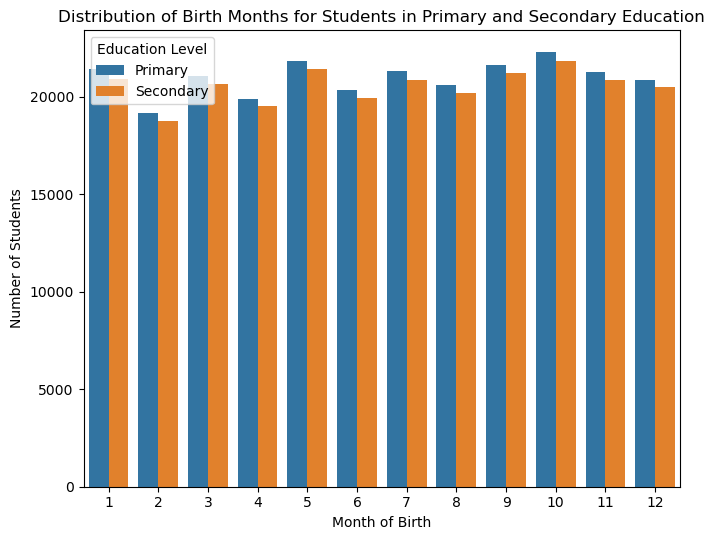

In [118]:
# ===============================
# Plot 1: Distribution of Birth Months
# ===============================
df_birth_months = df_combined[['CODI_ALUMNE', 'MES_NAIXEMENT', 'snapshot']].drop_duplicates()

# Order the months correctly, from 1 to 12
df_birth_months['MES_NAIXEMENT'] = pd.Categorical(df_birth_months['MES_NAIXEMENT'], 
                                                  categories=[str(i) for i in range(1, 13)], ordered=True)

plt.figure(figsize=(7, 5.5))
sns.countplot(data=df_birth_months, x='MES_NAIXEMENT', hue='snapshot')
plt.title('Distribution of Birth Months for Students in Primary and Secondary Education')
plt.xlabel('Month of Birth')
plt.ylabel('Number of Students')
plt.legend(title='Education Level', labels=['Primary', 'Secondary'])
plt.tight_layout()
plt.show()

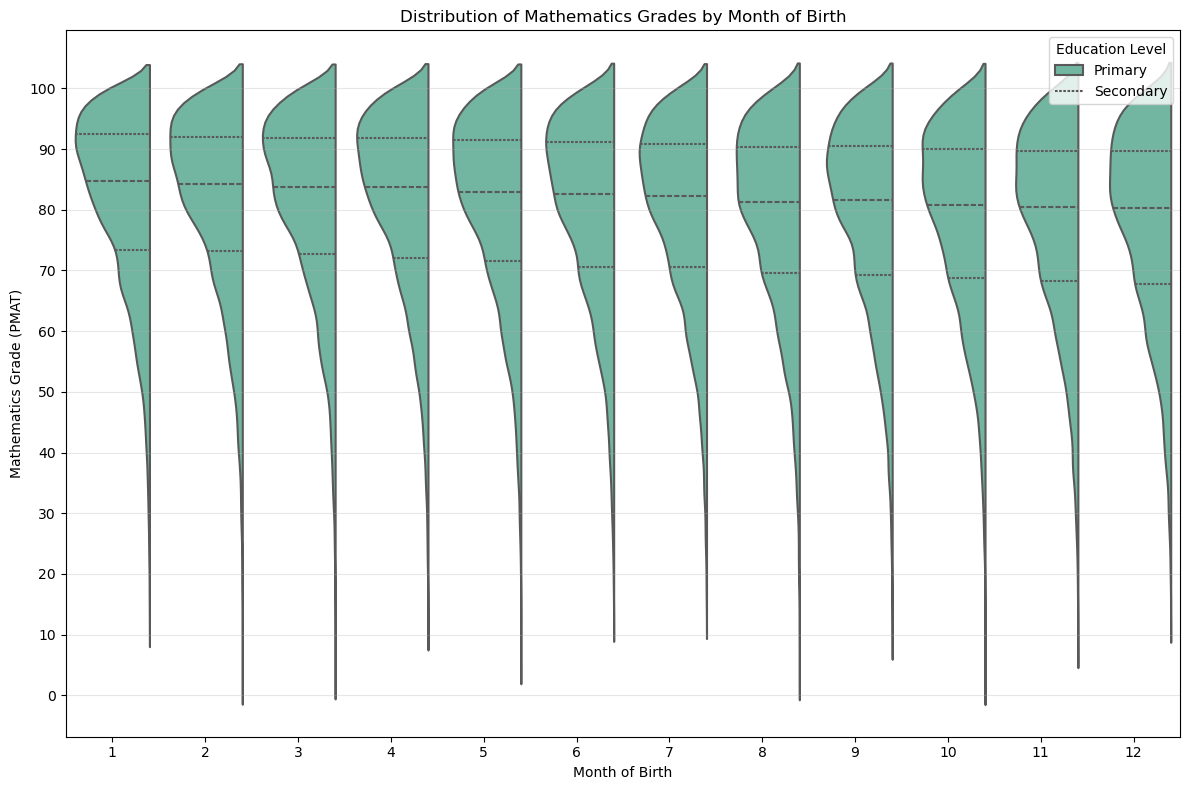

In [16]:
# ===============================
# Plot 2: Mathematics Grades by Birth Month (Violin Distribution)
# ===============================
df_math_grades = df_combined[['CODI_ALUMNE', 'MES_NAIXEMENT', 'PMAT', 'snapshot']].drop_duplicates(subset='CODI_ALUMNE')

# Order the months correctly, from 1 to 12
df_math_grades['MES_NAIXEMENT'] = pd.Categorical(df_math_grades['MES_NAIXEMENT'], categories=[str(i) for i in range(1, 13)], ordered=True)

plt.figure(figsize=(12, 8))
sns.violinplot(data=df_math_grades, x='MES_NAIXEMENT', y='PMAT', hue='snapshot', 
               palette='Set2', split=True, inner='quartile', linewidth=1.5)

# Set y-axis ticks every 10 points
plt.yticks(range(0, 101, 10))

plt.title('Distribution of Mathematics Grades by Month of Birth')
plt.xlabel('Month of Birth')
plt.ylabel('Mathematics Grade (PMAT)')
plt.legend(title='Education Level', labels=['Primary', 'Secondary'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()